In [1]:
import numpy as np 
import pandas as pd 
import re 
import os 
from tqdm import *

from matplotlib import pyplot as plt 
import seaborn as sns 

import pandas as pd 
from bs4 import BeautifulSoup

import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers 

import wget 
import nltk
from nltk.corpus import stopwords

In [2]:
tf.config.list_physical_devices("GPU")

2021-11-05 18:53:30.571767: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 18:53:30.604554: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 18:53:30.605007: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
df = pd.read_csv("Amazon_Fine_Food_Reviews/Reviews.csv") 
df[["Text", "Summary"]].head()

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy


In [4]:
df.drop_duplicates(subset=["Text"], inplace=True)
df.dropna(axis=0, inplace=True)
df[["Text", "Summary"]].head()

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy


In [5]:
contraction_mapping = {
    "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
    "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
    "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
    "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
    "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
    "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
    "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
    "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
    "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
    "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
    "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
    "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
    "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
    "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
    "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
    "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
    "you're": "you are", "you've": "you have"
}

In [6]:
df.drop(list(df.columns[:-2]), axis=1, inplace=True)

In [7]:
df.head()

,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


In [8]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /home/harish/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
def cleanText(text):
    lowText = text.lower()
    formatted = BeautifulSoup(lowText, "lxml").text 
    formatted = re.sub(r'\([^)]*\)', '', formatted)
    formatted = re.sub('"', '', formatted) 
    formatted = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in formatted.split()])
    formatted = re.sub(r"'s\b", "", formatted) 
    formatted = re.sub("[^a-zA-Z]", " ", formatted)
    tokens = [w for w in formatted.split() if not w in stop_words] 
    long_words = []
    for i in tokens: 
        if len(i) >= 3:
            long_words.append(i) 
    return (" ".join(long_words)).strip() 

def cleanSummary(text):
    formatted = re.sub('"', '', text)
    formatted = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in formatted.split()])
    formatted = re.sub(r"'s\b","",formatted)
    formatted = re.sub("[^a-zA-Z]", " ", formatted)
    formatted = formatted.lower()
    tokens = formatted.split()
    formatted = ''
    for i in tokens:
        if len(i) > 1:
            formatted = formatted + i + ' '
    return formatted 

cleaned_text = []
cleaned_summary = [] 

for t in tqdm(df["Text"], ascii=True, desc="Text Cleaning", ncols=100):
    cleaned_text.append(cleanText(t))

for t in tqdm(df["Summary"], ascii=True, desc="Summary Cleaning", ncols=100):
    cleaned_summary.append(cleanSummary(t))

df["Cleaned_Text"] = cleaned_text 
df["Cleaned_Summary"] = cleaned_summary

df["Cleaned_Summary"].replace('', np.nan, inplace=True)
df.dropna(axis=0, inplace=True)

Summary Cleaning: 100%|#################################| 393565/393565 [00:01<00:00, 217042.24it/s]


In [10]:
print(len(df))
df = df[df["Cleaned_Text"].str.split().str.len().gt(100)]
print(len(df))
df["Cleaned_Summary"] = df["Cleaned_Summary"].apply(lambda x : "_START_" + x + "_END_")

393222
19910


In [11]:
df.head()

,Summary,Text,Cleaned_Text,Cleaned_Summary
32,Best of the Instant Oatmeals,McCann's Instant Oatmeal is great if you must ...,mccann instant oatmeal great must oatmeal scra...,_START_best of the instant oatmeals _END_
41,Oatmeal For Oatmeal Lovers,McCann's makes oatmeal for every oatmeal conno...,mccann makes oatmeal every oatmeal connoisseur...,_START_oatmeal for oatmeal lovers _END_
52,You'll go nuts over Ass-Kickin' Peanuts.,This wasn't in stock the last time I looked. I...,stock last time looked vermont country store w...,_START_you ll go nuts over ass kickin peanuts ...
63,Hammer Nutrition 's Fizz Rocks!,I have used the endurolyte product for several...,used endurolyte product several years pill pow...,_START_hammer nutrition fizz rocks _END_
73,Warning! WARNING! -ALCOHOL SUGARS!,Buyer Beware Please! This sweetener is not for...,buyer beware please sweetener everybody maltit...,_START_warning warning alcohol sugars _END_


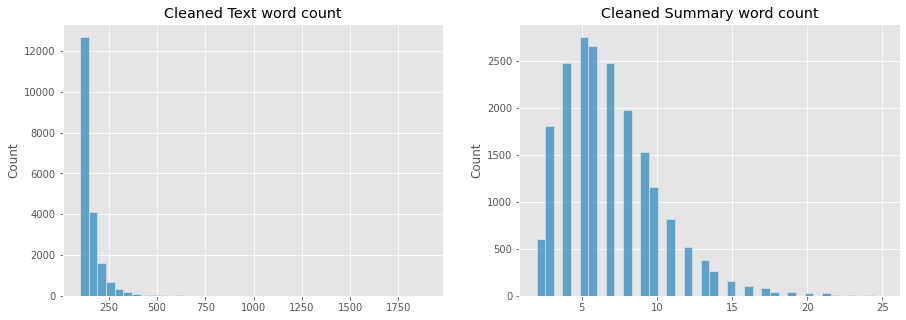

In [12]:
twc = []
swc = [] 

for i in df["Cleaned_Text"]:
    twc.append(len(i.split()))
for i in df["Cleaned_Summary"]:
    swc.append(len(i.split())) 

# ldf = pd.DataFrame({"text": twc, "summary": swc})
# ldf.hist(bins=40)

plt.style.use("ggplot")
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title("Cleaned Text word count")
sns.histplot(twc, bins=40)
plt.subplot(122)
plt.title("Cleaned Summary word count")
sns.histplot(swc, bins=40)
plt.show()

In [13]:
mlt = 80 
mls = 10 
x_train, x_val, y_train, y_val = train_test_split(df["Cleaned_Text"], df["Cleaned_Summary"], test_size=0.1, random_state=0, shuffle=True) 

In [14]:
x_tokenize = Tokenizer() 
x_tokenize.fit_on_texts(list(x_train))

x_train = x_tokenize.texts_to_sequences(x_train)
x_val = x_tokenize.texts_to_sequences(x_val) 
x_train = pad_sequences(x_train, maxlen = mlt, padding="post")
x_val = pad_sequences(x_val, maxlen = mlt, padding="post")

x_vocab_size = len(x_tokenize.word_index) + 1 


y_tokenize = Tokenizer() 
y_tokenize.fit_on_texts(list(y_train))

y_train = y_tokenize.texts_to_sequences(y_train)
y_val = y_tokenize.texts_to_sequences(y_val) 
y_train = pad_sequences(y_train, maxlen = mlt, padding="post")
y_val = pad_sequences(y_val, maxlen = mls, padding="post")

y_vocab_size = len(y_tokenize.word_index) + 1 

In [15]:
latent_dim = 100 

encoder_in = layers.Input(shape = (mlt, ))
encoder_embed = layers.Embedding(x_vocab_size, latent_dim,trainable=True)(encoder_in) 

enc_lstm1 = layers.LSTM(latent_dim, return_sequences=True,return_state=True)
enc_out1, state_h1, state_c1 = enc_lstm1(encoder_embed) 

enc_lstm2 = layers.LSTM(latent_dim, return_sequences=True,return_state=True)
enc_out2, state_h2, state_c2 = enc_lstm2(enc_out1)

enc_lstm3 = layers.LSTM(latent_dim, return_sequences=True,return_state=True)
enc_out3, state_h3, state_c3 = enc_lstm2(enc_out2)

decoder_in = layers.Input(shape = (None,)) 
decoder_embed_layer = layers.Embedding(y_vocab_size, latent_dim,trainable=True)
decoder_embed = decoder_embed_layer(decoder_in)

dec_lstm = layers.LSTM(latent_dim, return_sequences=True,return_state=True)
dec_out, dec_fstate, dec_bstate = dec_lstm(decoder_embed,initial_state=[state_h2, state_c2])

dec_dense = layers.TimeDistributed(layers.Dense(y_vocab_size,activation="softmax")) 

dec_out = dec_dense(dec_out)

model = models.Model([encoder_in, decoder_in], dec_out)
model.summary() 

2021-11-05 18:55:19.412597: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-05 18:55:19.413298: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 18:55:19.413612: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 18:55:19.413863: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 100)      5354200     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 100), (N 80400       embedding[0][0]                  
______________________________________________________________________________________________

In [16]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy") 

In [17]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [18]:
# earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min")
# modelCheckpoint = tf.keras.callbacks.ModelCheckpoint("./", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

hist = model.fit(
    [x_train, y_train[:, :-1]], 
    y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:, 1:], 
    epochs = 10, batch_size = 16, 
    validation_data = (
        [x_val, y_val[:, :-1]], 
        y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:]
    )
)

2021-11-05 18:55:25.277319: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2021-11-05 18:55:30.037148: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8300
Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /usr/local/cuda-11.0/lib64/libcublas.so.11: undefined symbol: cublasGetSmCountTarget


1120/1120 [==============================] - 66s 54ms/step - loss: 0.7767 - val_loss: 3.9700
Epoch 2/10
1120/1120 [==============================] - 60s 54ms/step - loss: 0.5258 - val_loss: 3.8736
Epoch 3/10
1120/1120 [==============================] - 61s 54ms/step - loss: 0.5085 - val_loss: 3.7606
Epoch 4/10
1120/1120 [==============================] - 61s 55ms/step - loss: 0.4882 - val_loss: 3.6752
Epoch 5/10
1120/1120 [==============================] - 60s 54ms/step - loss: 0.4685 - val_loss: 3.6186
Epoch 6/10
1120/1120 [==============================] - 61s 54ms/step - loss: 0.4502 - val_loss: 3.5931
Epoch 7/10
1120/1120 [==============================] - 61s 55ms/step - loss: 0.4333 - val_loss: 3.5705
Epoch 8/10
1120/1120 [==============================] - 63s 56ms/step - loss: 0.4169 - val_loss: 3.5732
Epoch 9/10
1120/1120 [==============================] - 64s 57ms/step - loss: 0.4011 - val_loss: 3.5772
Epoch 10/10
1120/1120 [==============================] - 61s 54ms/step - lo

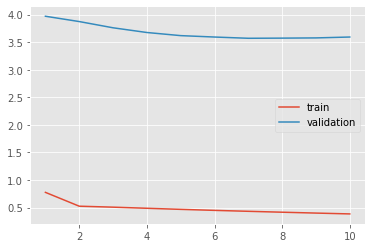

In [19]:
epochs = np.arange(1, 11)
plt.plot(epochs, hist.history["loss"], label="train")
plt.plot(epochs, hist.history["val_loss"], label="validation")
plt.legend()
plt.show()

In [20]:
reverse_target_word_index=y_tokenize.index_word 
reverse_source_word_index=x_tokenize.index_word 
target_word_index=y_tokenize.word_index

In [21]:
enc_model = models.Model(inputs = encoder_in, outputs = [enc_out3, state_h3, state_c3])

decoder_state_input_h = layers.Input(shape=(latent_dim, ))
decoder_state_input_c = layers.Input(shape=(latent_dim, ))
decoder_hidden_state_input = layers.Input(shape= (mlt, latent_dim))

dec_emb2 = decoder_embed_layer(decoder_in)

decoder_out, state_h2, state_c2 = dec_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

dec_out_2 = dec_dense(decoder_out)

decoderModel = models.Model(
    [decoder_in] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c], [dec_out_2] + [state_h2, state_c2]
)

In [22]:
def decodeSeq(inSeq):

    eo, eh, ec = enc_model.predict(inSeq)
    # print("Description: {}\ne_out: {}".format(inSeq, eo))
    targSeq = np.zeros((1, 1))
    
    targSeq[0, 0] = target_word_index["start"]
    stop = False 
    decoded = " "
    decLen = 0

    while not stop:

        outTokens, h, c = decoderModel.predict([targSeq] + [eo, eh, ec])
        sampleId = np.argmax(outTokens[0, -1, :])
        sampleToken = reverse_target_word_index[sampleId]
        # print("Sampled Token:", sampleToken)

        if sampleToken != "end":
            decoded += " " + sampleToken 
            decLen += 1

        if sampleToken == "end" or decLen >= mls - 1:
            stop = True 

        targSeq = np.zeros((1, 1))
        targSeq[0, 0] = sampleId
        eh, ec = h, c 

    return decoded 

In [23]:
def seq2Summary(inSeq):
    summary = "" 
    for i in inSeq:
        if (i!=0 and i!=target_word_index["start"]) and i!=target_word_index["end"]:
            summary += reverse_target_word_index[i] + " "
    return summary 

def seq2Text(inSeq):
    text = "" 
    for i in inSeq:
        if i!=0:
            text += reverse_source_word_index[i] + " "
    return text 

In [24]:
for i in range(len(x_val)):
    print("Description:", seq2Text(x_val[i]))
    print("Ground Truth:", seq2Summary(y_val[i]))
    print("Predicted Summary:", decodeSeq(x_val[i].reshape(1, mlt)))
    print("\n")

Description: side overpowering good shower still slightest hint fragrance left behind enough picked close enough tell couple feet away gel lathers nicely washes nicely real complaint using skin longer dry actually slightly oily severe dry skin perhaps product meant people problem dryness oiliness short term though skipping day skin returns normal nice product men dry skin smells nice leave feeling clean struggle severe dry skin product please like slightly dry skin may feel little oily afterward keep mind shopping bath products 
Ground Truth: from slightly dry to slightly oily 
Predicted Summary:   love this product


Description: oddities gravy still outstanding almost addictive would say price get delicious meal package takes minutes make still would recommend purchase would personally buy really good understand instead smokey tomato onion gravy actually end spicy onion gravy like spicy food would avoid however big fan indian curry mind spice cannot wrong expect much paneer much tikk

In [25]:
valOutDict = dict() 
for i in trange(len(x_val), ascii=True, desc="Prediction Histogram", ncols=100):
    pred = decodeSeq(x_val[i].reshape(1, mlt))
    if pred not in valOutDict:
        valOutDict[pred] = 0 
    valOutDict[pred] += 1 

Prediction Histogram: 100%|#####################################| 1991/1991 [06:24<00:00,  5.18it/s]


In [26]:
valOutDict.keys()

dict_keys(['  love this product', '  great for your dog', '  great for your own', '  great product', '  great for the price', '  great for the best', '  great for the money', '  great for your own and hair', '  great for my dog but not as good', '  great for your own and you can be', '  this is the best', '  great for your money', '  great for the taste and great price', '  great for your hair', '  this is the best thing have ever', '  great for my dog', '  great for my dog but not as good as', '  it is not as good as you', '  great for my dog but', '  works for the price', '  great product but not as good as well', '  great for my dog but it is not', '  great for my dog and you are not', '  great product but not as good', '  great for my dog but not as advertised', '  great for your dog but not as advertised'])

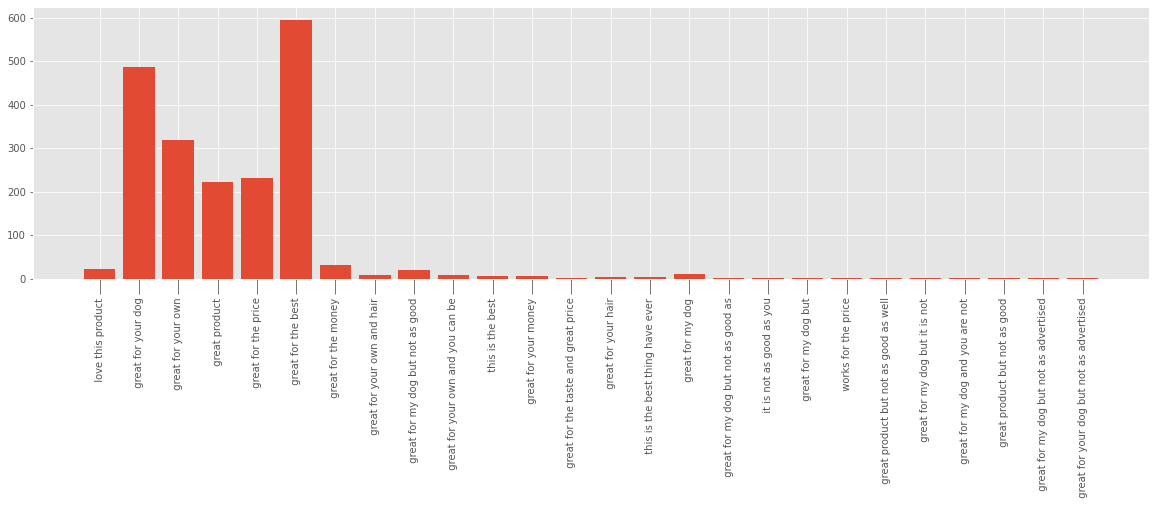

In [27]:
plt.figure(figsize = (20, 5))
plt.bar(valOutDict.keys(), valOutDict.values())
plt.tick_params(axis="x", rotation=90, size=15)
plt.show()

In [28]:
model.save("LSTM_Seq2Seq")

2021-11-05 19:19:25.793836: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: LSTM_Seq2Seq/assets


INFO:tensorflow:Assets written to: LSTM_Seq2Seq/assets
